In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from keras import Sequential
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_recall_fscore_support
)
import seaborn as sns

In [4]:
# 1️⃣ Load dataset
df_train = pd.read_csv("data/features/session_based_trainset.csv")
print("Training dataset shape:", df_train.shape)
df_test = pd.read_csv("data/features/session_based_testset.csv")
print("Testing dataset shape:", df_test.shape)

Training dataset shape: (488524, 280)
Testing dataset shape: (122132, 280)


In [5]:
# 2️⃣ Use the correct label column
label_col = "label"
print("Unique values in label:", df_train[label_col].unique())
print("Unique values in label:", df_test[label_col].unique()) #is this flip-flop the source of a problem? Don't think so

Unique values in label: [0 1]
Unique values in label: [1 0]


In [6]:
# 3️⃣ Prepare features and target
y_raw = df_train[label_col]
X = df_train.drop(columns=[label_col]).fillna(0)

ytest_raw = df_test[label_col]
X_test = df_test.drop(columns=[label_col]).fillna(0) #new x test

In [7]:
# 4️⃣ Convert label text/numbers → binary
def map_label(val):
    val_str = str(val).lower()
    if "benign" in val_str or val == 0 or val == "0":
        return 0
    else:
        return 1

y = y_raw.apply(map_label)
y_test = ytest_raw.apply(map_label) #new y test
print("\nBinary label distribution in train set (0=Benign, 1=Malicious):\n", y.value_counts())
print("\nBinary label distribution in test set (0=Benign, 1=Malicious):\n", y_test.value_counts())


Binary label distribution in train set (0=Benign, 1=Malicious):
 label
1    245470
0    243054
Name: count, dtype: int64

Binary label distribution in test set (0=Benign, 1=Malicious):
 label
0    61273
1    60859
Name: count, dtype: int64


In [8]:
# 5️⃣ Train/test split
'''X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("\nX Train:", X_train.shape, "X Test:", X_test.shape)'''

#no need to perform splits since there is an entire separate testing data set
X_train = X
y_train = y
print(X_train.shape)

(488524, 279)


In [ ]:
# 6️⃣ Train 1D CNN model
#this model with all these precise values here matches that of the paper to the letter, and probably won't work on other datasets bc of shape
"""cnn_model = Sequential()
cnn_model.add(layers.Conv1D(filters=50, kernel_size=5, strides=3, padding='valid', activation='relu', input_shape=(1480, 1)))
cnn_model.add(layers.Conv1D(filters=50, kernel_size=4, strides=3, padding='valid', activation='relu'))
cnn_model.add(layers.MaxPooling1D(pool_size=3, strides=3, padding='valid'))
cnn_model.add(layers.LSTM(units=50, return_sequences=True))
#may be a need for cropping here to get correct output size? idk
cnn_model.add(layers.Dense(units=500, activation='relu', dropout=0.5))
cnn_model.add(layers.Dense(units=50, activation='relu', dropout=0.5))
cnn_model.add(layers.Dense(units=12, activation='softmax'))"""
#this version is modified in terms of shape so that we can use it on the Mendley data set
clstm_model = Sequential()
clstm_model.add(layers.Conv1D(filters=64, kernel_size=5, strides=2, padding='valid', activation='relu', input_shape=(279, 1)))
clstm_model.add(layers.Conv1D(filters=64, kernel_size=3, strides=2, padding='valid', activation='relu'))
clstm_model.add(layers.MaxPooling1D(pool_size=2, strides=2, padding='valid'))
clstm_model.add(layers.LSTM(units=32, return_sequences=False))
clstm_model.add(layers.Dense(128, activation='relu'))
clstm_model.add(layers.Dropout(rate=0.5))
clstm_model.add(layers.Dense(units=32, activation='relu'))
clstm_model.add(layers.Dropout(rate=0.5))
clstm_model.add(layers.Dense(units=1, activation='sigmoid'))


clstm_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
clstm_model.fit(X_train, y_train, epochs=10, batch_size=32)

C:\Users\david\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
15267/15267 ━━━━━━━━━━━━━━━━━━━━ 134s 9ms/step - accuracy: 0.9119 - loss: 0.2159
Epoch 2/10
15267/15267 ━━━━━━━━━━━━━━━━━━━━ 135s 9ms/step - accuracy: 0.9721 - loss: 0.0770
Epoch 3/10
15267/15267 ━━━━━━━━━━━━━━━━━━━━ 144s 9ms/step - accuracy: 0.9777 - loss: 0.0603
Epoch 4/10
15267/15267 ━━━━━━━━━━━━━━━━━━━━ 147s 10ms/step - accuracy: 0.9804 - loss: 0.0521
Epoch 5/10
15267/15267 ━━━━━━━━━━━━━━━━━━━━ 139s 9ms/step - accuracy: 0.9818 - loss: 0.0498
Epoch 6/10
15267/15267 ━━━━━━━━━━━━━━━━━━━━ 130s 9ms/step - accuracy: 0.9828 - loss: 0.0465
Epoch 7/10
15267/15267 ━━━━━━━━━━━━━━━━━━━━ 136s 9ms/step - accuracy: 0.9841 - loss: 0.0430
Epoch 8/10
15267/15267 ━━━━━━━━━━━━━━━━━━━━ 129s 8ms/step - accuracy: 0.9849 - loss: 0.0411
Epoch 9/10
15267/15267 ━━━━━━━━━━━━━━━━━━━━ 136s 9ms/step - accuracy: 0.9855 - loss: 0.0391
Epoch 10/10
15267/15267 ━━━━━━━━━━━━━━━━━━━━ 132s 9ms/step - accuracy: 0.9859 - loss: 0.0382


In [ ]:
# 7️⃣ Evaluate model
y_pred_proba = clstm_model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)
loss, accuracy = clstm_model.evaluate(X_test, y_test, verbose=1)
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='binary')

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {fscore}")
print(f"Support: {support}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))
print("ROC AUC:", round(roc_auc_score(y_test, y_pred_proba), 4))

3817/3817 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step
3817/3817 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.9842 - loss: 0.0428
Test Loss: 0.0431
Test Accuracy: 0.9847
Precision: 0.9842562343013807
Recall: 0.9851295617739365
F1 Score: 0.9846927043983839
Support: None

Confusion Matrix:
[[60314   959]
 [  905 59954]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9852    0.9843    0.9848     61273
           1     0.9843    0.9851    0.9847     60859

    accuracy                         0.9847    122132
   macro avg     0.9847    0.9847    0.9847    122132
weighted avg     0.9847    0.9847    0.9847    122132

ROC AUC: 0.9989


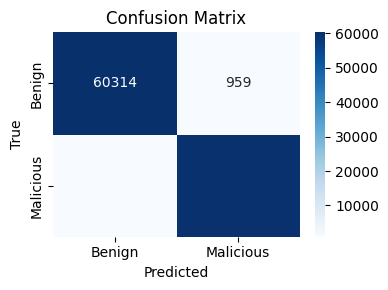

In [ ]:
# 8️⃣ Visualize Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Benign", "Malicious"],
            yticklabels=["Benign", "Malicious"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


In [ ]:
# 9️⃣ Feature Importance
#currently this seems to take forever to run, so I will maybe return to this
#perm = PermutationImportance(my_model, random_state=1).fit(X_train,y_train)
#eli5.show_weights(perm, feature_names = X_train.columns.tolist())

AttributeError: 'Sequential' object has no attribute 'feature_importances_'

In [ ]:
# 🔟 Save 
clstm_model.save("report/clstm_session_model.keras")
print("\nModel saved in report/")


Model saved in report/


In [2]:
# 11 CICIDS2017 data set testing setup
df2 = pd.read_csv("data/CICIDS2017/cicids2017_combined_relabled2.csv")
df2 = df2.iloc[:, 2:] #
label_col = " Label"
print("Unique values in label:", df2[label_col].unique())
y_raw2 = df2[label_col]
X2 = df2.drop(columns=[label_col]).fillna(0)
def map_label(val):
    val_str = str(val).lower()
    if "benign" in val_str or val == 0 or val == "0":
        return 0
    else:
        return 1
y2 = y_raw2.apply(map_label)
print("\nBinary label distribution (0=Benign, 1=Malicious):\n", y2.value_counts())

X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X2, y2, test_size=0.3, stratify=y2, random_state=42
)
print("\nTrain:", X_train2.shape, "Test:", X_test2.shape)

Unique values in label: ['BENIGN' 'DDoS' 'PortScan' 'Bot' 'Infiltration'
 'Web Attack � Brute Force' 'Web Attack � XSS'
 'Web Attack � Sql Injection' 'FTP-Patator' 'SSH-Patator' 'DoS slowloris'
 'DoS Slowhttptest' 'DoS Hulk' 'DoS GoldenEye' 'Heartbleed']

Binary label distribution (0=Benign, 1=Malicious):
  Label
0    2273097
1     557646
Name: count, dtype: int64

Train: (1981520, 78) Test: (849223, 78)


In [3]:
# 12 CICIDS2017 set testing training

#this version is modified in terms of shape so that we can use it on the CICIDS2017 data set
clstm_model2 = Sequential()
clstm_model2.add(layers.Conv1D(filters=64, kernel_size=5, strides=2, padding='valid', activation='relu', input_shape=(78, 1)))
clstm_model2.add(layers.Conv1D(filters=64, kernel_size=3, strides=2, padding='valid', activation='relu'))
clstm_model2.add(layers.MaxPooling1D(pool_size=2, strides=2, padding='valid'))
clstm_model2.add(layers.LSTM(units=32, return_sequences=False))
clstm_model2.add(layers.Dense(128, activation='relu'))
clstm_model2.add(layers.Dropout(rate=0.5))
clstm_model2.add(layers.Dense(units=32, activation='relu'))
clstm_model2.add(layers.Dropout(rate=0.5))
clstm_model2.add(layers.Dense(units=1, activation='sigmoid'))


clstm_model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
clstm_model2.fit(X_train2, y_train2, epochs=10, batch_size=32)

C:\Users\david\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
61923/61923 ━━━━━━━━━━━━━━━━━━━━ 258s 4ms/step - accuracy: 0.8835 - loss: 0.2871
Epoch 2/10
61923/61923 ━━━━━━━━━━━━━━━━━━━━ 282s 5ms/step - accuracy: 0.8028 - loss: 0.4965
Epoch 3/10
15267/61923 ━━━━━━━━━━━━━━━━━━━━ 3:31 5ms/step - accuracy: 0.8032 - loss: 0.4960

KeyboardInterrupt: 

26539/26539 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step
26539/26539 ━━━━━━━━━━━━━━━━━━━━ 61s 2ms/step - accuracy: 0.8026 - loss: 0.4967
Test Loss: 0.4962
Test Accuracy: 0.8030
Precision: 0.12113866425923436
Recall: 0.18848852917618086
F1 Score: 0.14748865175082262
Support: None

Confusion Matrix:
[[453157 228772]
 [135761  31533]]

Classification Report:
              precision    recall  f1-score   support

           0     0.7695    0.6645    0.7132    681929
           1     0.1211    0.1885    0.1475    167294

    accuracy                         0.5707    849223
   macro avg     0.4453    0.4265    0.4303    849223
weighted avg     0.6418    0.5707    0.6017    849223

ROC AUC: 0.3443


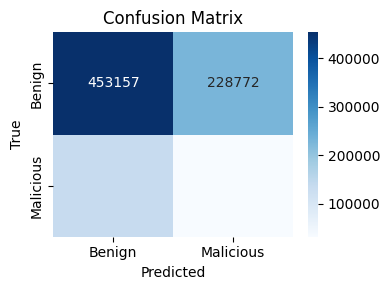

In [ ]:
# 13 CICIDS2017 set testing evaluation

y_pred_proba2 = clstm_model2.predict(X_test2)
y_pred2 = (y_pred_proba2 > 0.5).astype(int)
loss, accuracy = clstm_model2.evaluate(X_test2, y_test2, verbose=1)
precision, recall, fscore, support = precision_recall_fscore_support(y_test2, y_pred2, average='binary')

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {fscore}")
print(f"Support: {support}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test2, y_pred2))
print("\nClassification Report:")
print(classification_report(y_test2, y_pred2, digits=4))
print("ROC AUC:", round(roc_auc_score(y_test2, y_pred_proba2), 4))

cm = confusion_matrix(y_test2, y_pred2)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Benign", "Malicious"],
            yticklabels=["Benign", "Malicious"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

In [ ]:
# 14 Save CICIDS2017 model
clstm_model2.save("report/clstm2_session_model.keras")
print("\nModel saved in report/")


Model saved in report/


In [4]:
# 15 CTU13 data set testing setup
df3 = pd.read_csv("data/ctu13/CTU13_Combined_Traffic.csv")
label_col = "Label"
print("Unique values in label:", df3[label_col].unique())
y_raw3 = df3[label_col]
X3 = df3.drop(columns=[label_col]).fillna(0)
def map_label(val):
    val_str = str(val).lower()
    if "benign" in val_str or val == 0 or val == "0":
        return 0
    else:
        return 1
y3 = y_raw3.apply(map_label)
print("\nBinary label distribution (0=Benign, 1=Malicious):\n", y3.value_counts())

X_train3, X_test3, y_train3, y_test3 = train_test_split(
    X3, y3, test_size=0.3, stratify=y3, random_state=42
)
print("\nTrain:", X_train3.shape, "Test:", X_test3.shape)

Unique values in label: [1 0]

Binary label distribution (0=Benign, 1=Malicious):
 Label
0    53314
1    38898
Name: count, dtype: int64

Train: (64548, 57) Test: (27664, 57)


In [5]:
# 16 CTU13 set testing training

#this version is modified in terms of shape so that we can use it on the CTU13 data set
clstm_model3 = Sequential()
clstm_model3.add(layers.Conv1D(filters=64, kernel_size=5, strides=2, padding='valid', activation='relu', input_shape=(57, 1)))
clstm_model3.add(layers.Conv1D(filters=64, kernel_size=3, strides=2, padding='valid', activation='relu'))
clstm_model3.add(layers.MaxPooling1D(pool_size=2, strides=2, padding='valid'))
clstm_model3.add(layers.LSTM(units=32, return_sequences=False))
clstm_model3.add(layers.Dense(128, activation='relu'))
clstm_model3.add(layers.Dropout(rate=0.5))
clstm_model3.add(layers.Dense(units=32, activation='relu'))
clstm_model3.add(layers.Dropout(rate=0.5))
clstm_model3.add(layers.Dense(units=1, activation='sigmoid'))


clstm_model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
clstm_model3.fit(X_train3, y_train3, epochs=10, batch_size=32)

Epoch 1/10


C:\Users\david\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2018/2018 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7890 - loss: 0.4238
Epoch 2/10
2018/2018 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8628 - loss: 0.2825
Epoch 3/10
2018/2018 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8595 - loss: 0.2924
Epoch 4/10
2018/2018 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8847 - loss: 0.2537
Epoch 5/10
2018/2018 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8849 - loss: 0.2602
Epoch 6/10
2018/2018 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8881 - loss: 0.2386
Epoch 7/10
2018/2018 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9095 - loss: 0.2034
Epoch 8/10
2018/2018 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9119 - loss: 0.2196
Epoch 9/10
2018/2018 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8993 - loss: 0.2288
Epoch 10/10
2018/2018 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9080 - loss: 0.2102


865/865 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
865/865 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9161 - loss: 0.1924
Test Loss: 0.1908
Test Accuracy: 0.9174
Precision: 0.9729865940933373
Recall: 0.8271636675235647
F1 Score: 0.8941688666574036
Support: None

Confusion Matrix:
[[15726   268]
 [ 2017  9653]]

Classification Report:
              precision    recall  f1-score   support

           0     0.8863    0.9832    0.9323     15994
           1     0.9730    0.8272    0.8942     11670

    accuracy                         0.9174     27664
   macro avg     0.9297    0.9052    0.9132     27664
weighted avg     0.9229    0.9174    0.9162     27664

ROC AUC: 0.9653


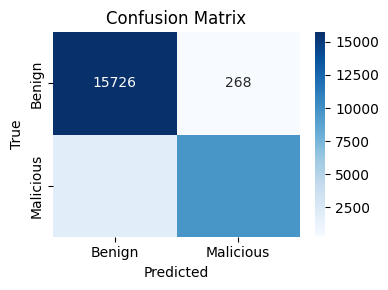

In [6]:
# 17 CTU13 set testing evaluation

y_pred_proba3 = clstm_model3.predict(X_test3)
y_pred3 = (y_pred_proba3 > 0.5).astype(int)
loss, accuracy = clstm_model3.evaluate(X_test3, y_test3, verbose=1)
precision, recall, fscore, support = precision_recall_fscore_support(y_test3, y_pred3, average='binary')

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {fscore}")
print(f"Support: {support}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test3, y_pred3))
print("\nClassification Report:")
print(classification_report(y_test3, y_pred3, digits=4))
print("ROC AUC:", round(roc_auc_score(y_test3, y_pred_proba3), 4))

cm = confusion_matrix(y_test3, y_pred3)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Benign", "Malicious"],
            yticklabels=["Benign", "Malicious"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

In [ ]:
# 18 Save CTU13 model
clstm_model3.save("report/clstm3_session_model.keras")
print("\nModel saved in report/")


Model saved in report/
